# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

# Описание данных

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Примечание.** Если объединение таблиц командой merge приводит к ошибке dead kernell, примените join.

# Шаг 1. Файлы с данными и общая информация

Импортируем библиотеки.

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

Откроем имеющиеся данные и изучим информацию о них.

In [2]:
calls_df = pd.read_csv('datasets/calls.csv')
internet_df = pd.read_csv('datasets/internet.csv', index_col=0)
messages_df = pd.read_csv('datasets/messages.csv')
tariffs_df = pd.read_csv('datasets/tariffs.csv')
users_df = pd.read_csv('datasets/users.csv')

for i in [(calls_df, "Информация о звонках"), (internet_df, "Информация об интернет-сессиях"), \
          (messages_df, "Информация о сообщениях"), (users_df, "Информация о пользователях"), \
          (tariffs_df, "Информация о тарифах")]:
    display(i[0].head().style.set_caption(i[1]))
    i[0].info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000000,1000
1,1000_1,2018-08-17,0.000000,1000
2,1000_2,2018-06-11,2.850000,1000
3,1000_3,2018-09-21,13.800000,1000
4,1000_4,2018-12-15,5.180000,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.950000,2018-11-25,1000
1,1000_1,1052.810000,2018-09-07,1000
2,1000_2,1197.260000,2018-06-25,1000
3,1000_3,550.270000,2018-08-22,1000
4,1000_4,302.560000,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,nan,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,nan,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,nan,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,nan,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,nan,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Основная информация, необходимая для анализа находится в трех датафреймах: calls_df, internet_df, messages_df, в которых отсутствую пропущенные значения. Часть нужных данных (тариф и город) находятся в датафрейме users_df.

# Шаг 2. Подготовка данных

Для начала проверим наличие явных дубликатов в calls_df, internet_df, messages_df.

In [3]:
for i in [calls_df, internet_df, messages_df]:
    print(i.duplicated().sum())

0
0
0


Как можно видеть, явные дубликаты отстутствуют.

Заменим тип данных, в котором записана дата в этих датафреймах со строкового на datetime.

In [4]:
calls_df["call_date"] = pd.to_datetime(calls_df["call_date"], format="%Y-%m-%d")
internet_df["session_date"] = pd.to_datetime(internet_df["session_date"], format="%Y-%m-%d")
messages_df["message_date"] = pd.to_datetime(messages_df["message_date"], format="%Y-%m-%d")

Для предотвращения ошибок в данных, проверим, действительно ли все наблюдения получены в 2018 году.

In [5]:
list(calls_df["call_date"].dt.year.unique()) + list(internet_df["session_date"].dt.year.unique()) + list(messages_df["message_date"].dt.year.unique())

[2018, 2018, 2018]

В каждый датафрейм добавим столбец содержащий номер месяца

In [6]:
calls_df["call_date_month"] = calls_df["call_date"].dt.month
internet_df["session_date_month"] = internet_df["session_date"].dt.month
messages_df["message_date_month"] = messages_df["message_date"].dt.month

Округлим продолжительность звонков в датафрейме calls_df до целых значений в большую сторону с помощью функции np.ceil().

In [7]:
calls_df["duration"] = np.ceil(calls_df["duration"])

Сгруппируем датафреймы. Найдем ежемесячное количество звонков и их продолжительность (в минутах), количество отправленных сообщений, объем израсходованного интернет-трафика (в мегабайтах). Переименуем столбцы для последующего соединения таблиц.

In [8]:
calls_df_group = (calls_df.groupby(["user_id", "call_date_month"])["duration"]
                        .agg(["count", "sum"]).reset_index()
                        .set_axis(["user_id", "month", "calls_number", "calls_duration_min"], axis="columns"))

messages_df_group = (messages_df.groupby(["user_id", "message_date_month"])["id"]
                     .agg("count").reset_index()
                     .set_axis(["user_id", "month", "messages_number"], axis="columns"))

internet_df_group = (internet_df.groupby(["user_id", "session_date_month"])["mb_used"].agg("sum")
                     .reset_index().set_axis(["user_id", "month", "traffic_mb"], axis="columns"))

Соединим таблицы calls_df_group, messages_df_group, internet_df_group и добавим к ним название тарифа и город абонента из users_df. После этого заменим пропущенные значения на 0.

In [9]:
df = (calls_df_group.merge(messages_df_group, on=["user_id", "month"], how="outer")
      .merge(internet_df_group, on=["user_id", "month"], how="outer")
      .merge(users_df[["user_id", "tariff", "city"]], on="user_id", how="outer")
      .sort_values(["user_id", "month"])
      .reset_index(drop=True))
df = df.fillna(0)

Добавим в датафрейм df колонку traffic_gb со значениями израсходованного интернет-трафика в гигабайтах, получившиеся значения округлим до целых в большую сторону с помощью np.ceil(). Проверим результат объединения.

In [10]:
df["traffic_gb"] = np.ceil(df["traffic_mb"] / 1024)
display(df.head())
df.info()

,user_id,month,calls_number,calls_duration_min,messages_number,traffic_mb,tariff,city,traffic_gb
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,3.0
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,23.0
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,14.0
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,14.0
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,15.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             3216 non-null   int64  
 1   month               3216 non-null   float64
 2   calls_number        3216 non-null   float64
 3   calls_duration_min  3216 non-null   float64
 4   messages_number     3216 non-null   float64
 5   traffic_mb          3216 non-null   float64
 6   tariff              3216 non-null   object 
 7   city                3216 non-null   object 
 8   traffic_gb          3216 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 226.2+ KB


Заменим тип данных month, calls_number, calls_duration_min, messages_number на целочисленный.

In [11]:
df[["month", "calls_number", "messages_number", "calls_duration_min"]] = \
df[["month", "calls_number", "messages_number", "calls_duration_min"]].astype("int")

Посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану). Для этого создадим функцию и протестирум ее.

In [12]:
# датафрейм с информацией о тарифах, в качестве индекса задано название тарифа
tariffs_df_index_name = tariffs_df.set_index("tariff_name")

def revenue_func(data):
    '''Функция принимает на вход датафрейм из которого использует строки:
       длительность звонков, количество СМС, объем интернет-трафика и название тарифа, 
       возвращает помесячную выручку с каждого пользователя.
       Инорфация о тарифах берется из tariffs_df_index_name
    '''
    if data['tariff'] in tariffs_df_index_name.index:
        return (
        tariffs_df_index_name.loc[data['tariff'], 'rub_monthly_fee'] 
        +
        (0 if (data["calls_duration_min"] - tariffs_df_index_name.loc[data['tariff'], 'minutes_included']) <= 0 
         else (data["calls_duration_min"] - tariffs_df_index_name.loc[data['tariff'], 'minutes_included']) 
               * tariffs_df_index_name.loc[data['tariff'], 'rub_per_minute'])
        +
        (0 if (data["messages_number"] - tariffs_df_index_name.loc[data['tariff'], 'messages_included']) <= 0 
         else (data["messages_number"] - tariffs_df_index_name.loc[data['tariff'], 'messages_included']) 
               * tariffs_df_index_name.loc[data['tariff'], 'rub_per_message'])
        +
        (0 if (data["traffic_gb"] - tariffs_df_index_name.loc[data['tariff'], 'mb_per_month_included'] / 1024) <= 0 
         else (data["traffic_gb"] - tariffs_df_index_name.loc[data['tariff'], 'mb_per_month_included'] / 1024) 
               * tariffs_df_index_name.loc[data['tariff'], 'rub_per_gb'])
    )    
    else:
        return np.NaN
    
#Тест функции
df_test = pd.DataFrame([(400, 40, 14, "smart"), 
                       (600, 70, 20, "smart"),
                       (2900, 990, 25, "ultra"),
                       (3100, 1200, 50, "ultra"),
                       (1100, 500, 40, "unknown")],
                      columns = ["calls_duration_min", "messages_number", "traffic_gb", "tariff"])

df_test["revenue_rub"] = df_test.apply(revenue_func, axis=1)
df_test.head()

,calls_duration_min,messages_number,traffic_gb,tariff,revenue_rub
0,400,40,14,smart,550.0
1,600,70,20,smart,1910.0
2,2900,990,25,ultra,1950.0
3,3100,1200,50,ultra,5250.0
4,1100,500,40,unknown,NaN


Функция revenue_func прошла тест, применим ее к датафрейму df и создадим колонку с выручкой от каждого пользователя, после этого проверим результат.

In [13]:
df["revenue_rub"] = df.apply(revenue_func, axis=1)
display(df.head())
df.info()

,user_id,month,calls_number,calls_duration_min,messages_number,traffic_mb,tariff,city,traffic_gb,revenue_rub
0,1000,5,22,159,22,2253.49,ultra,Краснодар,3.0,1950.0
1,1000,6,43,172,60,23233.77,ultra,Краснодар,23.0,1950.0
2,1000,7,47,340,75,14003.64,ultra,Краснодар,14.0,1950.0
3,1000,8,52,408,81,14055.93,ultra,Краснодар,14.0,1950.0
4,1000,9,58,466,57,14568.91,ultra,Краснодар,15.0,1950.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             3216 non-null   int64  
 1   month               3216 non-null   int64  
 2   calls_number        3216 non-null   int64  
 3   calls_duration_min  3216 non-null   int64  
 4   messages_number     3216 non-null   int64  
 5   traffic_mb          3216 non-null   float64
 6   tariff              3216 non-null   object 
 7   city                3216 non-null   object 
 8   traffic_gb          3216 non-null   float64
 9   revenue_rub         3216 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 251.4+ KB


# Шаг 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Для начала сравним гистограммы помесячной длительности звонков абонентов тарифов smart и ultra.

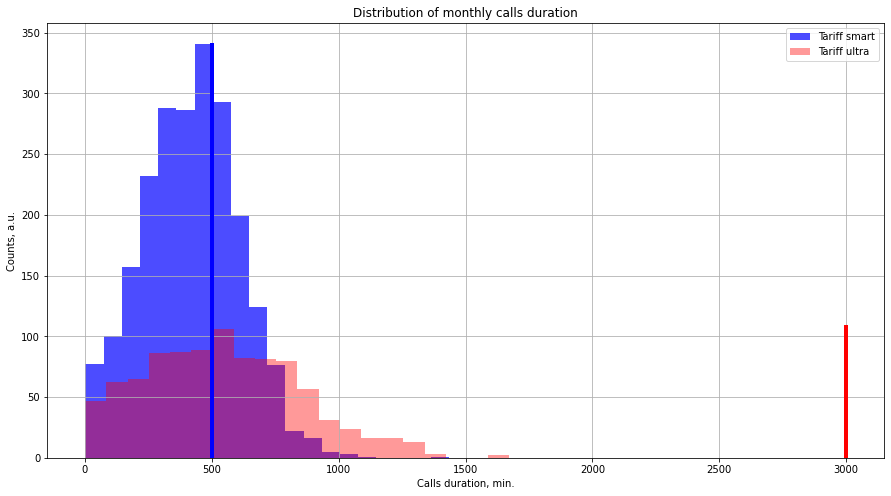

In [14]:
(df.query("tariff == 'smart' and calls_duration_min != 0")["calls_duration_min"]
 .hist(bins=20, figsize=(15,8), alpha=0.7, color="blue"))
(df.query("tariff == 'ultra' and calls_duration_min != 0")["calls_duration_min"]
 .hist(bins=20, alpha=0.4, color="red"))
plt.legend(["Tariff smart", "Tariff ultra"])
plt.ylabel("Counts, a.u.")
plt.xlabel("Calls duration, min.")
plt.title("Distribution of monthly calls duration")
plt.axvline(x=tariffs_df_index_name.loc['smart', 'minutes_included'], ymin=0, ymax=0.95, c="blue", ls="-", lw=4)
plt.axvline(x=tariffs_df_index_name.loc['ultra', 'minutes_included'], ymin=0, ymax=0.3, c="red", ls="-", lw=4)
plt.show()

Построим гистограммы количества СМС, отправляемых абонентами тарифов smart и ultra каждый месяц.

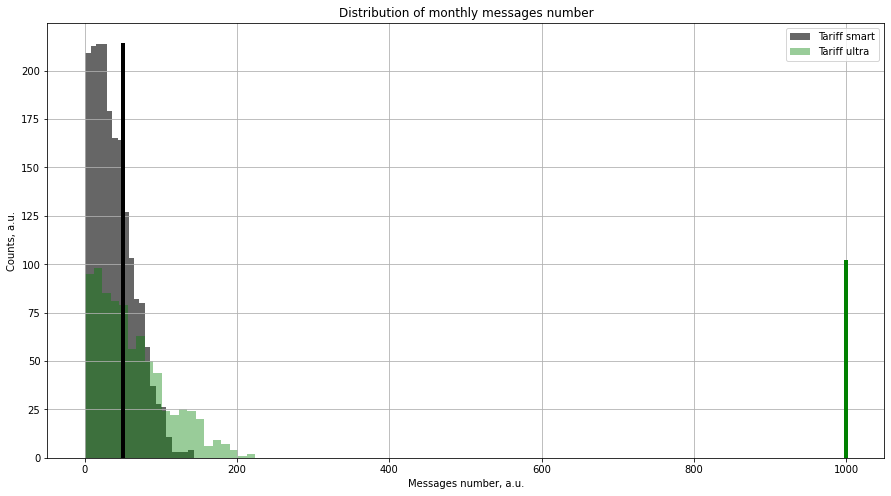

In [15]:
(df.query("tariff == 'smart' and messages_number != 0")["messages_number"]
 .hist(bins=20, figsize=(15,8), alpha=0.6, color="black"))
(df.query("tariff == 'ultra' and messages_number != 0")["messages_number"]
 .hist(bins=20, alpha=0.4, color="green"))
plt.legend(["Tariff smart", "Tariff ultra"])
plt.ylabel("Counts, a.u.")
plt.xlabel("Messages number, a.u.")
plt.title("Distribution of monthly messages number")
plt.axvline(x=tariffs_df_index_name.loc['smart', 'messages_included'], ymin=0, ymax=0.95, c="black", ls="-", lw=4)
plt.axvline(x=tariffs_df_index_name.loc['ultra', 'messages_included'], ymin=0, ymax=0.45, c="green", ls="-", lw=4)
plt.show()

Посмотрим как изменяются гистограммы израсходованного интернет-трафика для двух групп абонентов.

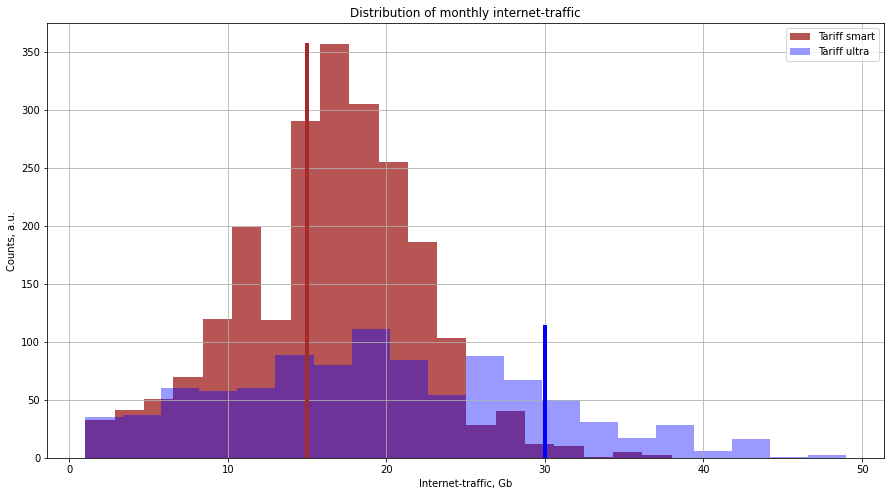

In [16]:
(df.query("tariff == 'smart' and traffic_gb != 0")["traffic_gb"]
 .hist(bins=20, figsize=(15,8), alpha=0.8, color="brown"))
(df.query("tariff == 'ultra' and traffic_gb != 0")["traffic_gb"]
 .hist(bins=20, alpha=0.4, color="blue"))
plt.legend(["Tariff smart", "Tariff ultra"])
plt.ylabel("Counts, a.u.")
plt.xlabel("Internet-traffic, Gb")
plt.title("Distribution of monthly internet-traffic")
plt.axvline(x=(tariffs_df_index_name.loc['smart', 'mb_per_month_included'] / 1024), ymin=0, ymax=0.95, c="brown", ls="-", lw=4)
plt.axvline(x=(tariffs_df_index_name.loc['ultra', 'mb_per_month_included'] / 1024), ymin=0, ymax=0.3, c="blue", ls="-", lw=4)
plt.show()

Построенные гистаграммы показывают, что распределения для тарифа ultra характеризуются более высокими значениями меры центральной тенденции и более высоким разбросом в отличие от распределений для тарифа smart. Кроме этого можно наблюдать слабую скошенность найденных распределений, а также, что количество абонентов тарифа smart превосходит количество абонентов тарифа ultra. 

Определим долю абонентов каждаго из тарифов, посчитаем медиану, среднее количество, дисперсию и стандартное отклонение.

In [17]:
print("Доля каждого из тарифов:", df["tariff"].value_counts(normalize=True), sep="\n", end="\n\n")

(df.query("calls_duration_min != 0 and messages_number != 0 and traffic_gb != 0")
.groupby("tariff")["calls_duration_min", "messages_number", "traffic_gb"]
.agg(["median", "mean", "var", "std"]).astype("int"))

Доля каждого из тарифов:
smart    0.693408
ultra    0.306592
Name: tariff, dtype: float64



calls_duration_min                  messages_number                 \
                   median mean    var  std          median mean   var std   
tariff                                                                      
smart                 427  421  35030  187              34   38   719  26   
ultra                 539  559  96254  310              52   61  1981  44   

       traffic_gb               
           median mean var std  
tariff                          
smart          17   16  32   5  
ultra          19   19  88   9

Можно видеть, что доля абонентов, подключенных к тарифу smart примерно в 2 раза больше абонентов, подключенных к тарифу ultra: 70 и 30 %, соответственно. В среднем абоненты тарифа smart расходуют в месяц 421 минуту, 34 СМС и 16 Гб интернет-трафика. Эти значения близки к лимитам тарифа (500 минут, 50 СМС, 15 Гб), что может говорить о малых дополнительных платежах данных абонентов. Средние значения абонентов тарифа ultra ожидаемо превосходят значения тарифа smart: 559 минут, 61 СМС, 19 Гб интернет-трафика. Интересно отметить, что найденные значения заметно ниже лимитов, предоставляемых тарифом (3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика), что может говорить об избыточности тарифа для части абонентов и их возможной переплате за услуги связи. Найденные значения дисперсии и среднеквадратичного отклонения говорят о высоком разбросе значений продолжительности звонков, количества СМС и объема израсходованного интернет-трафика относительно среднего значения, что говорит о значительных отличиях в поведении абонентов. Кроме этого, можно отметить, что найденные значения медианы распределений близки к среднему значению и это сигнализирует о слабой скошенности анализируемых данных.

# Шаг 4. Проверка гипотез

Вначале, сравним гистограммы помесячной выручки для каждого тарифа и выручки пользователей из Москвы и других регионов.

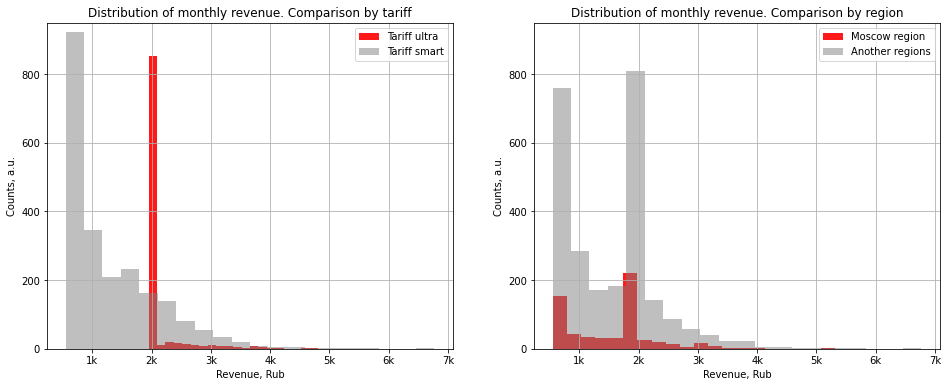

In [18]:
ax1 = plt.subplot(1, 2, 1)
(df.query("tariff == 'ultra' and revenue_rub != 0")["revenue_rub"]
.hist(bins=20, figsize=(16,6), alpha=0.9, color="red", ax=ax1))
(df.query("tariff == 'smart' and revenue_rub != 0")["revenue_rub"]
.hist(bins=20, alpha=0.5, color="grey"))
plt.legend(["Tariff ultra", "Tariff smart"])
plt.ylabel("Counts, a.u.")
plt.xlabel("Revenue, Rub")
plt.title("Distribution of monthly revenue. Comparison by tariff")
plt.ylim(0, 950)
plt.xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000], 
           ["1k", "2k", "3k", "4k", "5k", "6k", "7k"])
ax2 = plt.subplot(1, 2, 2)
(df.query("city == 'Москва' and revenue_rub != 0")["revenue_rub"]
.hist(bins=20, figsize=(16,6), alpha=0.9, color="red", ax=ax2))
(df.query("city != 'Москва' and revenue_rub != 0")["revenue_rub"]
.hist(bins=20, alpha=0.5, color="grey"))
plt.legend(["Moscow region", "Another regions"])
plt.ylabel("Counts, a.u.")
plt.xlabel("Revenue, Rub")
plt.title("Distribution of monthly revenue. Comparison by region")
plt.ylim(0, 950)
plt.xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000], 
           ["1k", "2k", "3k", "4k", "5k", "6k", "7k"])
plt.show()

Полученные данные показывают, что распределения помесячной выручки в зависимости от тарифа существенно отличаются. Пик распределения для тарифа smart смещен влево от пика распределения для тарифа ultra и находится в районе 500 рублей, что соответствует величине абонентской платы. Пик распределения для тарифа ultra в свою очередь также расположен в районе абонентской платы данного тарифа (2000 рублей).
   
Гистограммы помесячной выручки для региона Москва и остальных очень походят друг на друга, обе имеют бимодальный характер с модами в районе 500 и 2000 рублей и схожий разброс значений. Однако они отличаются разным количеством абонентов, в Москве абонентов меньше по сравнению с суммой абонентов в других регионах.

Сравним насколько отличается суммарная выручка за 2018 год для разных тарифов и регионов.

In [19]:
display("Суммарная выручка для тарифа Ультра: " + str(df.query("tariff == 'ultra' and revenue_rub != 0")["revenue_rub"].sum()) + " руб.")
display("Суммарная выручка для тарифа Смарт: " + str(df.query("tariff == 'smart' and revenue_rub != 0")["revenue_rub"].sum()) + " руб.")
display("Суммарная выручка в Москве: " + str(df.query("city == 'Москва' and revenue_rub != 0")["revenue_rub"].sum()) + " руб.")
display("Суммарная выручка в регионах (без учета Москвы): " + str(df.query("city != 'Москва' and revenue_rub != 0")["revenue_rub"].sum()) + " руб.")

'Суммарная выручка для тарифа Ультра: 2041050.0 руб.'

'Суммарная выручка для тарифа Смарт: 2875901.0 руб.'

'Суммарная выручка в Москве: 945042.0 руб.'

'Суммарная выручка в регионах (без учета Москвы): 3971909.0 руб.'

Можно видеть, что суммарная выручка оператора на тарифе Ультра соответствует примерно 40 %, а выручка в Москве примерно 20 % общей выручки, что является высокими величинами, не заментыми, на первый взгляд, из гистограмм.

**Сформулируем нулевую и альтернативную гипотезы для средней выручки пользователей тарифов «Ультра» и «Смарт»:**
- $H_0$ - средние выручки пользователей тарифов «Ультра» и «Смарт» равны
- $H_1$ - средняя выручка пользователей тарифа «Ультра» выше таковой тарифа «Смарт» (т.к. пик распределения тарифа "Ультра" существенно сдвинут вправо)

In [20]:
reveneu_ultra = df.query("tariff == 'ultra' and revenue_rub != 0")["revenue_rub"]
reveneu_smart = df.query("tariff == 'smart' and revenue_rub != 0")["revenue_rub"]

# критический уровень статистической значимости
alpha = 0.05 

print("Среднее значение выручки тарифа Ультра:", reveneu_ultra.mean(), "руб.")
print("Среднее значение выручки тарифа Смарт:", reveneu_smart.mean(), "руб.")

results = st.ttest_ind(reveneu_ultra, reveneu_smart)

print("p-значение:", results.pvalue / 2)

if ((results.pvalue / 2) < alpha) and (reveneu_ultra.mean() > reveneu_smart.mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее значение выручки тарифа Ультра: 2070.030425963489 руб.
Среднее значение выручки тарифа Смарт: 1289.6417040358745 руб.
p-значение: 4.0409547777449665e-161
Отвергаем нулевую гипотезу


Можно видеть, что среднее значение выручки на тарифе "Ультра" больше значения на тарифе "Смарт", а также полученное p-значение с большим запасом укладывается в критический уровень статистической значимости. Можно сказать, вероятность получить такую или большую разность в выборочных средних в рассматриваемых выборках практически равна нулю.

**Сформулируем нулевую и альтернативную гипотезы для средней выручки пользователей из Москвы из других регионов:**
- $H_0$ - средние выручки пользователей из Москвы и из других регионов равны
- $H_1$ - средние выручки пользователей из Москвы и из других регионов отличаются (т.к. распределения соответствуют друг другу и сложно выдвинуть одностороннюю гипотезу)

In [21]:
reveneu_moscow = df.query("city == 'Москва' and revenue_rub != 0")["revenue_rub"]
reveneu_regions = df.query("city != 'Москва' and revenue_rub != 0")["revenue_rub"]

# критический уровень статистической значимости
alpha1 = 0.05 

print("Среднее значение выручки для Москвы:", reveneu_moscow.mean(), "руб.")
print("Среднее значение выручки для остальных регионов:", reveneu_regions.mean(), "руб.")

results1 = st.ttest_ind(reveneu_moscow, reveneu_regions)

print("p-значение:", results1.pvalue)

if results1.pvalue < alpha1:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее значение выручки для Москвы: 1546.7135842880523 руб.
Среднее значение выручки для остальных регионов: 1524.7251439539348 руб.
p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 54%, хотя средние значения выручек отличаются. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними величиными выручек в Москве и регионах.

# Шаг 5. Общий вывод

В работе проведен анализ поведения абонентов тарифных планов "Смарт" и "Ультра" сотового оператора "Мегалайн". В результате удалось выявить следующие закономерности:
- Распределения длины телефонных звонков, количества СМС, объема интернет-трафика для тарифа "Ультра" характеризуются более высокими значениями среднего и дисперсии в отличие от распределений тарифа "Смарт". Данные распределения характеризуются слабой скошенностью.
- Средние значения помесячной длительности звонков, количества СМС и объема интернет-трафика для тарифа "Смарт" близки к лимитам тарифа (500 минут, 50 СМС, 15 Гб), а для тарифа "Ультра" заметно ниже лимитов, предоставляемых тарифом (3000 минут, 1000 СМС и 30 Гб).
- С высокой долей вероятности, среднее значение выручки на тарифе "Ультра" больше значения на тарифе "Смарт" (вероятность стремится к 100%), а средние значения выручек в Москве и других регионах равны (вероятность около 54%).
- Лучшим тарифом можно считать Ультра, т.к. он приносит больше средней помесячной выручки, а также из-за того, что абоненты не используют тарифные лимиты полностью, снижая нагрузку на инфраструктуру оператора.
- В настоящее время примерно 60 % выручки оператору приносят пользователи тарифа Смарт, с учетом того, что средняя выручка выше на тарифе Ультра, то при проведении маркетинговых кампаний и перетоке абонентов со Смарт на Ультра возможен рост общей выручки.